In [1]:
from argparse import Namespace
import matplotlib.pyplot as plt
import numpy as np
import random
import pprint
import torch

In [2]:
# Arguments
args = Namespace(
    seed=1024,
    num_samples_per_class=500,
    dimensions=2,
    num_classes=3,
    train_size=0.75,
    test_size=0.25,
    num_hidden_units=500,
    learning_rate=1e-0,
    regularization=1e-3,
    num_epochs=200,
)

# Set seed for reproducability
np.random.seed(args.seed)
pprint.pprint(vars(args),indent = 4)

{   'dimensions': 2,
    'learning_rate': 1.0,
    'num_classes': 3,
    'num_epochs': 200,
    'num_hidden_units': 500,
    'num_samples_per_class': 500,
    'regularization': 0.001,
    'seed': 1024,
    'test_size': 0.25,
    'train_size': 0.75}


In [3]:
# Generate non-linear data
def generate_data(num_samples_per_class, dimensions, num_classes):
    # Make synthetic spiral data
    X_original = np.zeros((num_samples_per_class*num_classes, dimensions))
    y = np.zeros(num_samples_per_class*num_classes, dtype='uint8')
    for j in range(num_classes):
        ix = range(num_samples_per_class*j,num_samples_per_class*(j+1))
        r = np.linspace(0.0,1,num_samples_per_class) # radius
        t = np.linspace(j*4,(j+1)*4,num_samples_per_class) + \
        np.random.randn(num_samples_per_class)*0.25 # theta
        X_original[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j

    # Stack
    print(np.shape(X_original))
    X = np.hstack([X_original])
    return X, y

In [4]:
# Generate X & y
X, y = generate_data(num_samples_per_class=args.num_samples_per_class, 
                     dimensions=args.dimensions, num_classes=args.num_classes)
print ("X: {0}".format(np.shape(X)))
print ("y: {0}".format(np.shape(y)))

(1500, 2)
X: (1500, 2)
y: (1500,)


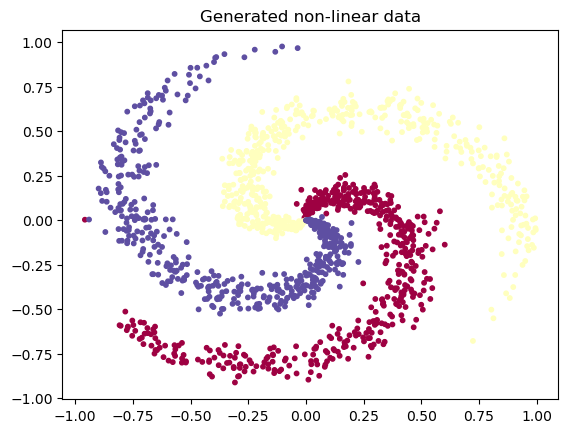

In [5]:
# Visualize data
plt.title("Generated non-linear data")
plt.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap=plt.cm.Spectral)
plt.show()

In [6]:
print(type(X),type(y))
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()
print(X.type(),y.type())
print(X)
print(y)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
torch.FloatTensor torch.LongTensor
tensor([[ 0.0000e+00,  0.0000e+00],
        [ 1.4252e-04,  1.9989e-03],
        [ 1.4851e-03,  3.7227e-03],
        ...,
        [-3.8856e-01,  9.1707e-01],
        [-3.5308e-01,  9.3345e-01],
        [-5.6905e-01,  8.2230e-01]])
tensor([0, 0, 0,  ..., 2, 2, 2])


In [7]:
z = random.sample(range(0,len(X)),len(X))
s_index = torch.LongTensor(z)
print(z)
X = X[s_index]
y = y[s_index]
test_index_s = int(len(X) * args.train_size)
print(test_index_s)
X_train = X[:test_index_s]
y_train = y[:test_index_s]
X_test = X[test_index_s:]
y_test = y[test_index_s:]
print("This case contians %i train samples and %i test samples" % (len(X_train), len(y_test)))

[1107, 1434, 576, 1153, 256, 363, 535, 1114, 549, 423, 520, 305, 525, 1226, 1026, 614, 171, 400, 217, 36, 1302, 791, 1027, 971, 155, 982, 1384, 1449, 341, 371, 528, 1118, 984, 41, 1295, 138, 260, 991, 796, 209, 1204, 1049, 804, 733, 1291, 1070, 318, 911, 941, 1317, 66, 1400, 885, 106, 20, 152, 1437, 478, 643, 1035, 226, 1041, 587, 1411, 1216, 2, 1376, 44, 126, 745, 338, 367, 234, 1171, 1485, 1333, 466, 647, 809, 19, 1405, 250, 319, 333, 46, 1301, 829, 533, 360, 191, 1344, 384, 1258, 781, 967, 1082, 1483, 14, 1228, 438, 838, 345, 890, 1086, 1150, 1368, 950, 537, 539, 1261, 609, 501, 34, 95, 279, 1423, 998, 649, 84, 1362, 181, 1010, 1127, 419, 47, 1329, 372, 924, 58, 288, 59, 1104, 476, 124, 1047, 321, 114, 1155, 1233, 1044, 632, 355, 689, 1093, 1349, 635, 848, 1448, 957, 903, 1378, 168, 205, 714, 1372, 1255, 936, 728, 1464, 382, 111, 461, 9, 289, 221, 933, 93, 1394, 1067, 394, 481, 407, 154, 1224, 828, 917, 433, 460, 568, 249, 884, 999, 202, 432, 1338, 1125, 206, 798, 530, 1303, 1184, 8

In [8]:
# test for a liner model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

In [9]:
class LogisticClassifier(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim):
        super(LogisticClassifier,self).__init__()#get init func from nn.Module
        self.fc1 = nn.Linear(input_dim,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)
        self.fc3 = nn.Linear(hidden_dim,output_dim)

    def forward(self,x_in,apply_Softmax = False):
        a_1 = self.fc1(x_in)
        a_2 = self.fc2(a_1)
        y_pred = self.fc3(a_2)

        if apply_Softmax :
            y_pred = F.softmax(y_pred,dim=1)

        return y_pred

In [10]:
model = LogisticClassifier(input_dim=args.dimensions, 
                           hidden_dim=args.num_hidden_units, 
                           output_dim=args.num_classes)
print (model.named_modules)

<bound method Module.named_modules of LogisticClassifier(
  (fc1): Linear(in_features=2, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=3, bias=True)
)>


In [11]:
loss_f = nn.CrossEntropyLoss()#which contains the softmax, so in train step Softmax = False
optimizer = optim.Adam(model.parameters(),lr = args.learning_rate)

In [12]:
def get_Accuracy(y_pred,y_target):
    n_correct = torch.eq(y_pred,y_target).sum().item()
    # how mant numbers about y_pred[element] == y_target[element]
    accuracy = n_correct / len(y_pred) * 100
    return accuracy

In [13]:
for t in range(args.num_epochs):
    y_pred = model(X_train)
    _,predictions = y_pred.max(dim = 1)#index of the max value of y_pred
    accuracy = get_Accuracy(y_pred=predictions.long(),y_target=y_train)
    loss = loss_f(y_pred,y_train)

    if t%10 == 0:
        print( " epoch: {0:02d} | loss: {1:.4f} | accuracy: {2:.1f}%".format(
            t, loss, accuracy
        )
             )
        print(" ----- ----- ----- ----- ----- ----- ----- ----- ")
        print("y_pred:", y_pred)
        print("predicitions:",predictions)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

 epoch: 00 | loss: 1.1675 | accuracy: 31.6%
 ----- ----- ----- ----- ----- ----- ----- ----- 
y_pred: tensor([[-0.0967, -0.2023,  0.1892],
        [-0.0294, -0.0507,  0.0812],
        [-0.0769, -0.1660,  0.1599],
        ...,
        [-0.1082, -0.1939,  0.1975],
        [-0.1642, -0.2746,  0.2737],
        [-0.0640, -0.1762,  0.1509]], grad_fn=<AddmmBackward0>)
predicitions: tensor([2, 2, 2,  ..., 2, 2, 2])
 epoch: 10 | loss: 28894.4512 | accuracy: 54.8%
 ----- ----- ----- ----- ----- ----- ----- ----- 
y_pred: tensor([[-20438.7305,  38261.1211,  14174.3799],
        [-48935.9492,  18596.4805,  23382.0742],
        [-30908.9531,  33627.6016,  14575.8164],
        ...,
        [ -6953.9360,  36865.4805,  22128.9062],
        [ 28126.6035,  46923.2500,  27073.6211],
        [-46210.8516,  35306.5703,   5439.8057]], grad_fn=<AddmmBackward0>)
predicitions: tensor([1, 2, 1,  ..., 1, 1, 1])
 epoch: 20 | loss: 9430.3809 | accuracy: 55.9%
 ----- ----- ----- ----- ----- ----- ----- ----- 
y_pre

In [14]:
_,pred_train = model(X_train,apply_Softmax = True).max(dim = 1)
_,pred_test = model(X_test,apply_Softmax = True).max(dim = 1)
print("pred_train:",pred_train)
print("----- ----- ----- ----- -----")
print("pred_test:",pred_test)


pred_train: tensor([2, 2, 2,  ..., 2, 0, 2])
----- ----- ----- ----- -----
pred_test: tensor([1, 1, 1, 2, 1, 0, 2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 2, 1, 2, 2,
        0, 0, 2, 0, 0, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 0, 1, 2, 0, 2, 0, 2,
        1, 2, 1, 1, 2, 2, 1, 0, 0, 2, 1, 2, 1, 2, 0, 2, 2, 1, 2, 0, 1, 0, 1, 2,
        0, 1, 1, 2, 2, 1, 1, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 2, 0, 1, 2, 0,
        1, 0, 1, 2, 1, 2, 0, 2, 2, 1, 0, 0, 2, 2, 0, 0, 1, 2, 1, 1, 0, 0, 2, 1,
        2, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 0, 2, 0, 2, 2, 1,
        2, 0, 0, 0, 2, 0, 2, 1, 1, 1, 0, 1, 2, 1, 1, 0, 1, 0, 2, 1, 0, 0, 1, 1,
        1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 2, 2, 1, 2, 1, 0, 1, 1, 2, 0, 2, 1, 1, 2,
        0, 1, 0, 2, 0, 0, 1, 2, 0, 1, 2, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 1, 1, 0,
        1, 2, 1, 1, 0, 2, 2, 1, 1, 2, 1, 0, 1, 0, 2, 0, 0, 1, 0, 1, 0, 1, 2, 1,
        2, 1, 1, 2, 1, 2, 1, 1, 0, 2, 2, 2, 1, 2, 1, 1, 2, 1, 0, 0, 1, 1, 1, 1,
        1, 2, 1, 1, 2, 1, 0, 0, 1,

In [15]:
# Train and test accuracies
train_acc = get_Accuracy(y_pred=pred_train, y_target=y_train)
test_acc = get_Accuracy(y_pred=pred_test, y_target=y_test)
print ("train acc: {0:.1f}%, test acc: {1:.1f}%".format(train_acc, test_acc))

train acc: 55.9%, test acc: 50.4%


In [16]:
def plot_multiclass_decision_boundary(model,X,y):
    x_min = X[:,0].min()-0.1
    x_max = X[:,0].max() + 0.1
    y_min = X[:,1].min() - 0.1
    y_max = X[:,1].max() + 0.1
    print("x_max:",x_max)
    print("x_min:",x_min)
    print("y_max:",y_max)
    print("y_min:",y_min)
    xx,yy = np.meshgrid( np.linspace( x_min,x_max,101 ),np.linspace( y_min,y_max,101 ) )
    print("----- ----- ----- ----- ----- -----")

    print("xx:",xx)

    print("----- ----- ----- ----- ----- -----")

    print("yy:",yy)

    X_test = torch.from_numpy(np.c_[xx.ravel(),yy.ravel()]).float()

    print("----- ----- ----- ----- ----- -----")

    print("x_test:",X_test)
    
    y_pred = model(X_test,apply_Softmax = True)
    _,y_pred = y_pred.max(dim = 1)
    y_pred = y_pred.reshape(xx.shape)

    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    

x_max: tensor(1.0965)
x_min: tensor(-1.0579)
y_max: tensor(1.0765)
y_min: tensor(-1.0114)
----- ----- ----- ----- ----- -----
xx: [[-1.05791044 -1.0363662  -1.01482196 ...  1.05342503  1.07496927
   1.09651351]
 [-1.05791044 -1.0363662  -1.01482196 ...  1.05342503  1.07496927
   1.09651351]
 [-1.05791044 -1.0363662  -1.01482196 ...  1.05342503  1.07496927
   1.09651351]
 ...
 [-1.05791044 -1.0363662  -1.01482196 ...  1.05342503  1.07496927
   1.09651351]
 [-1.05791044 -1.0363662  -1.01482196 ...  1.05342503  1.07496927
   1.09651351]
 [-1.05791044 -1.0363662  -1.01482196 ...  1.05342503  1.07496927
   1.09651351]]
----- ----- ----- ----- ----- -----
yy: [[-1.01142991 -1.01142991 -1.01142991 ... -1.01142991 -1.01142991
  -1.01142991]
 [-0.99055029 -0.99055029 -0.99055029 ... -0.99055029 -0.99055029
  -0.99055029]
 [-0.96967067 -0.96967067 -0.96967067 ... -0.96967067 -0.96967067
  -0.96967067]
 ...
 [ 1.03477265  1.03477265  1.03477265 ...  1.03477265  1.03477265
   1.03477265]
 [ 1.0556

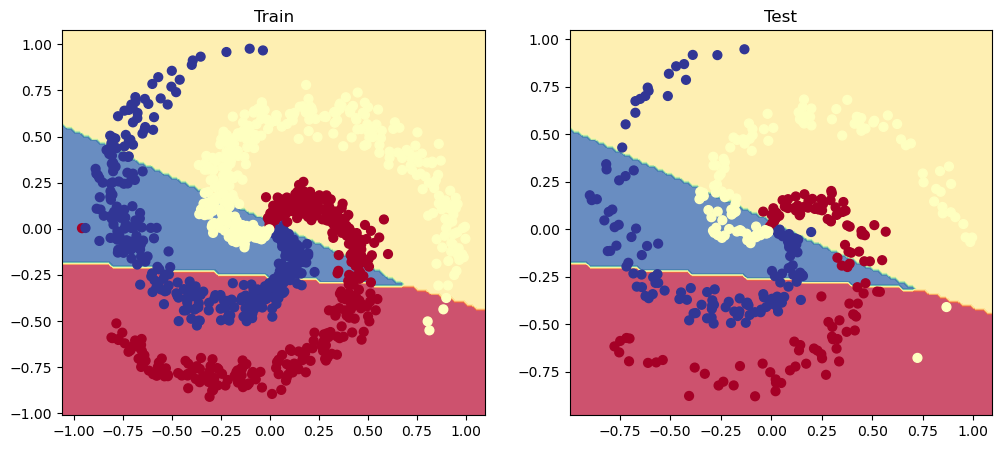

In [17]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()


In [18]:
# apply noliner model by multilayer Perceptron
class MLP(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim):
        super(MLP,self).__init__()
        self.fc1 = nn.Linear(input_dim,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)
        self.fc3 = nn.Linear(hidden_dim,output_dim)
    def forward(self,x_in,apply_softmax = False):
        a1 = F.relu(self.fc1(x_in))
        a2 = F.relu(self.fc2(a1))
        y_pred = self.fc3(a2)

        if apply_softmax:
            y_pred = F.softmax(y_pred,dim=1)

        return y_pred

In [19]:
model = MLP(
    input_dim=args.dimensions,
    hidden_dim=args.num_hidden_units,
    output_dim=args.num_classes
)
print(model.named_modules)
print(model.named_parameters)

<bound method Module.named_modules of MLP(
  (fc1): Linear(in_features=2, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=3, bias=True)
)>
<bound method Module.named_parameters of MLP(
  (fc1): Linear(in_features=2, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=3, bias=True)
)>


In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters()
                      ,lr = args.learning_rate)

In [21]:
for t in range(args.num_epochs):
    y_pred = model(X_train)
    _,predictions = y_pred.max(dim=1)
    accuracy = get_Accuracy(y_pred=predictions.long(),y_target=y_train)

    loss = loss_fn(y_pred,y_train)

    if t%10 == 0:
        print("epoch: {0:02d} | loss: {1:.4f} | accuracy: {2:.1f}%".format(
            t,loss,accuracy
        ))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

epoch: 00 | loss: 1.1170 | accuracy: 31.6%
epoch: 10 | loss: 58.6472 | accuracy: 64.1%
epoch: 20 | loss: 2.6106 | accuracy: 78.5%
epoch: 30 | loss: 1.0796 | accuracy: 83.3%
epoch: 40 | loss: 0.2869 | accuracy: 90.2%
epoch: 50 | loss: 0.2517 | accuracy: 90.8%
epoch: 60 | loss: 0.2019 | accuracy: 92.4%
epoch: 70 | loss: 0.1762 | accuracy: 92.4%
epoch: 80 | loss: 2.5019 | accuracy: 85.2%
epoch: 90 | loss: 0.7768 | accuracy: 87.7%
epoch: 100 | loss: 0.4834 | accuracy: 88.7%
epoch: 110 | loss: 0.4730 | accuracy: 89.2%
epoch: 120 | loss: 0.1695 | accuracy: 92.0%
epoch: 130 | loss: 0.3369 | accuracy: 92.5%
epoch: 140 | loss: 0.3021 | accuracy: 93.0%
epoch: 150 | loss: 0.1403 | accuracy: 93.0%
epoch: 160 | loss: 0.1389 | accuracy: 93.1%
epoch: 170 | loss: 0.1379 | accuracy: 93.1%
epoch: 180 | loss: 0.1368 | accuracy: 93.2%
epoch: 190 | loss: 0.1355 | accuracy: 93.2%
